In a previous notebook, we have shown how to [fit a psychometric curve using pyTorch](https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html). Here, I would like to review some nice properies of the logistic regression model (WORK IN PROGRESS). 

<!-- TEASER_END -->

Let's first initialize the notebook:

# quelques définitions

## initialisation du notebook

Nous allons importer quelques librairies qui seront utilisées pour la manipulation numérique de matrices et l'affichage:

In [5]:
import time
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [6]:
fig_width = 10
phi = np.sqrt(5)/2 + 1/2
figsize = (fig_width, fig_width/phi)

## Définition des variables et fonctions

... utiles pour réaliser une classification  de données synthétiques selon une régression logistique

On va utiliser des données organisés suivant des échantillons (de taille `N_batch`) pour lesquels on va avoir la relation suivante pour calculer le vecteur de sortie $Y$ de taille $K$ en fonction du vecteur d'entrée $X$ de taille $N$ :

$$
Y \approx \mathcal{B}( \sigma( \bar{X} \bar{W}^T ) )  
$$

où:
* $\mathcal{B}(p)$ représente un tirage de Bernoulli et $\approx$ représente que c'est un tirage de cette loi avec le paramètre $p$,
* $\sigma$ est la fonction sigmiode,
* $\bar{X}$ est le vectuer $X$ auquel on a rajouté un $1$ pour calculer le biais (sur la dernière ligne),
* $\bar{W}$ est la matrice de poids augmentée des biais (sur la dernière ligne) et donc de taille $K+1 \times (N+1)$.


In [7]:
N = 256 # nombre de valeurs de l'entrée
n_classes = 10 # nombre de classes
N_batch = 347 # nombre d'échantillons
seed = 1973

np.random.seed(seed)
W_scale = 1.
W = W_scale * np.random.randn(n_classes, N+1) # FIXED design matrix of weights (w) according to classes

# Definition de l'évidence (e) 
def evidence(W, X):
    """
    Modèle génératif de l'évidence:
    W[:-1, :] = N poids pour n_classes
    W[-1, :] = 1 biais pour chaque classe
    """
    e = (X @ W[:, :-1].T) + W[:, -1] 
    return e

# Transformation de l'entrée (e) en probabilité (p) selon une courbe de regression logistique
def sigmoid(logodds):
    return 1 / (1 + np.exp(-logodds))

def get_data(W, seed, N_batch, X_scale = .5, X_type='normal'):
    N, n_classes = W.shape[1]-1, W.shape[0]
    np.random.seed(seed)
    # nos entrées (X) : n_batch échantillons comprenant chacun N valeurs
    # tirage de causes aléatoires
    if X_type=='normal':
        X = X_scale * np.random.randn(N_batch, N)
    elif  X_type=='poisson':
        X = X_scale * np.random.poisson(size=(N_batch, N))
    else: # 'binary'
        X = X_scale > np.random.rand(N_batch, N)
        
    # modèle génératif: mélange
    e = evidence(W, X)
    p = sigmoid(e)
    # Tirage de Bernoulli : si p > à random => 1, si p < à random = 0 
    y = p > np.random.rand(N_batch, n_classes) # Bernoulli, generate data 
    
    return X, p, y, e

In [10]:
X, p, y, e = get_data(W, seed, N_batch)
e = evidence(W, X)

In [11]:
X, p, y, e = get_data(W, seed, N_batch) 
X.shape, e.shape, p.shape, y.shape, W.shape

((347, 256), (347, 10), (347, 10), (347, 10), (10, 257))

Avec __X,p,y = get_data(W, seed, N_batch)__ on appelle la fct get_data, qui appelle la fonction `sigmoid`, qui appelle la fonction evidence afin de nous renvoyer les entrées X (100 entrées, comprenant chacune 256 valeures), les probabilités de classification de ces différentes entrées dans les différentes classes (p), et la classification après tirage de bernoulli (y = succès si p > 0.5, echcec si p < 0.5). Pour visualiser les sorties (p et y) en fonction des entrées (X et e), on les stock dans des arrays. 

## Visualisation des données

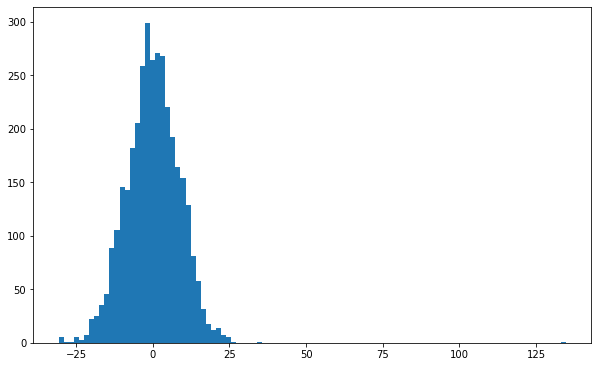

In [6]:
fig, ax = plt.subplots(figsize=figsize)
counts, bins, _ = ax.hist(e.ravel(), bins=100) 

Visualisation de p en fonction de e pour une classe :

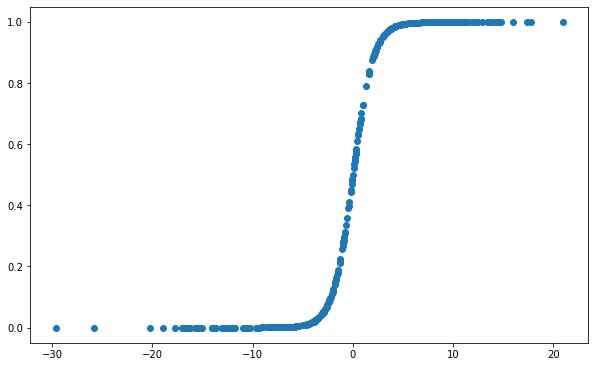

In [7]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(e[:,1], p[:,1]) 

Visualisation de p en fonction de e pour une classe + de la sortie (tirage de Bernoulli = y) 

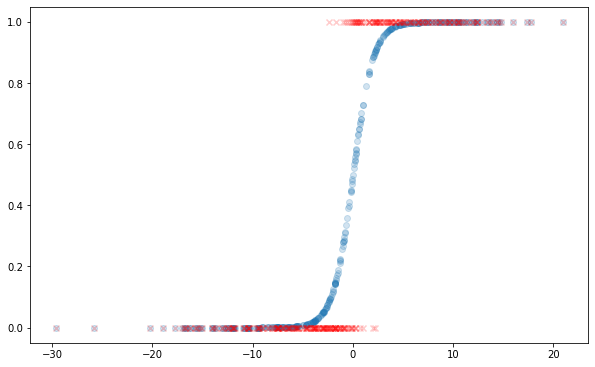

In [8]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(e[:,1],p[:,1], alpha=.2) #proba de e d'être classifié dans classe 1
ax.scatter(e[:,1],y[:,1], alpha=.2, marker="x", color="red") #Sortie de Bernoulli 

Visualisation de la distribution des probabilités de classification 

(array([1353.,  153.,   86.,   70.,   47.,   64.,   81.,   83.,  139.,
        1394.]),
 array([4.71559811e-14, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

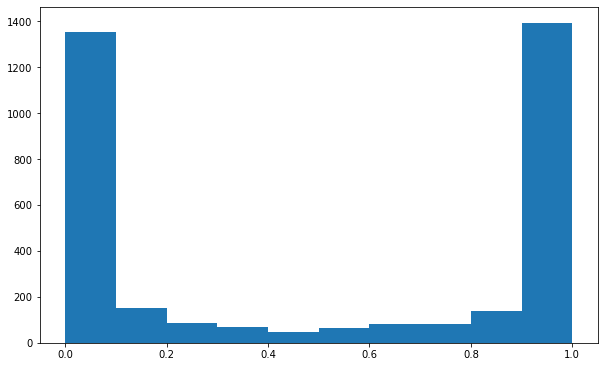

In [9]:
fig, ax = plt.subplots(figsize=figsize)
ax.hist(p.ravel(), bins=10)

Distribution qui se rapproche d'une beta distribution.

Visualisation de p en fonction de chaque entrée X + de la sortie y  'permise' par l'ajout des w et biais 

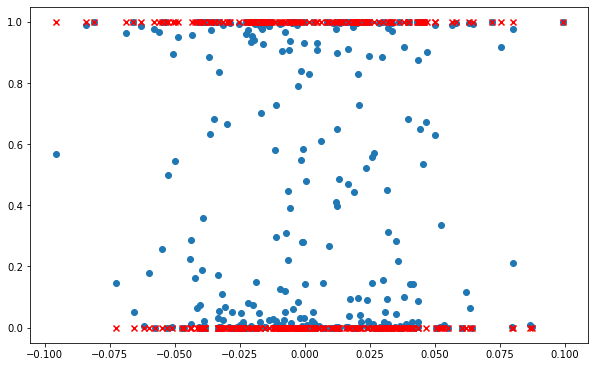

In [10]:
X_1 = np.mean(X,1)
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(X_1,p[:,1]) 
ax.scatter(X_1,y[:,1],marker="x", color="red")

... la situation est plus confuse... est-ce quon va arriver à distinguer les différents cas?

# Inversion par apprentissage supervisé

## Définition du réseau d'inversion

In [36]:
X.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
from torchsummary import summary

torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size//the sum of the output will be divided by the number of elements in the output
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output 

class LogisticRegressionModel(torch.nn.Module):
    
    # voir ce que signifie self 
    # voir ce que signifie super 
    
    def __init__(self, N, n_classes, bias=True): # (self, input_dim, output_dim)
        super(LogisticRegressionModel, self).__init__() 
        
        # 1ere couche : self.linear = torch.nn.Linear(input_dim, output_dim, bias=true) bias = true pour apprentissage
        self.linear = torch.nn.Linear(N, n_classes, bias=bias) 
        
        # 2e couche : self.nl = torch.nn.Sigmoid() = ouputs 
        # autre µpossibilité : self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid()
    
    # maintenant qu'on a définit les couches, on peut les utiliser dans la classe:
    # - self.linear me donne l'accumulation d'évidence,
    # - self.nl me donne la sigmoïde de e 
    
    def forward(self, X):
        # X = (N, n_batch) là on est dans 1 batch donc X = 256 = N 
        return self.nl(self.linear(X))

 __init__ permet de définir notre NN, les couches, leur role, la dimention des entrées et sorties
 
On a un réseau composé de deux couches : 
- la première (self.linear) réalise une transformation linéaire de nos entrées X (de dimention N =  256) de sorte à ce que la sortie y = (w*x)+biais = e (de dimention n_classes = 10). Une entrée sera associée aux différentes classes avec un w et un biais associé pour chacune des classes. Après plusieurs batch, on obtiendra plusieurs e pour la même ent alors plusieurs e pour chaque classes.
    
- la deuxième (self.nl) transforme ces sorties (e) pour leur donner une distribution sigmoïde. On obtient ainsi la probabilité de classification de l'entrée X, associée à un poid w et au biais. On aura n_classes sigmoïdes, représentant la probabilité de classification de l'entrée dans chacune des classes en fonction du w et du biais associé. 

La fonction __forward__ permet de construire le réseau en connectant les couches selon un modèle forward : self.nl(self.linear(X))

Par la suite, le réseau va modifier ses paramètres : w et biais de sorte à ce que la classification des X se fasse de la même manière que pendant l'initialisation

-> Pour cela, on demande à notre réseau de calculer la loss function entre la classification réalisée par self.nl(self.linear(X)) et celle réalisée par y 

-> Plus la différence est grande, plus la loss function l'est aussi et plus le réseau va modifier ses paramètres (W et biais) pour classifier de la même façon que pdt l'initialisation 

-> On devrait donc retrouver à la fin des W et des biais similaires entre ceux fixés par nous pendant l'initialisation et ceux déterminés par le réseau pdt l'inversion 


In [2]:
logistic_model = LogisticRegressionModel(N, n_classes) #(input_dim, output_dim)
#NN = float(N)
#summary(logistic_model, NN, batch_size=batch_size)

NameError: name 'N' is not defined

In [ ]:
bias_before_training = logistic_model.linear.bias
w_before_training = logistic_model.linear.weight
#bias_before_training.shape # shape = 10 car 1 biais associé à une classe, pour tous les x 
#w_before_training.shape # shape =  ([10, 256]) car pour chaque classe, on attribue 1 poid à chaque X

## Définition des variables d'apprentissage, d'entrée et de sortie

In [3]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1 # epoch = le nombre de passages dans l'ensemble des données d'entraînement que le réseau a effectués, ici 513 max
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

batch_size = 100
n_classes= 10

X = torch.randn(N_batch, N)
outputs = logistic_model(X)


NameError: name 'N_batch' is not defined

## Défition des fonctions pour l'apprentissage des w et biais pour classification

In [9]:
y.shape

NameError: name 'y' is not defined

In [45]:
def fit_data(X, y, learning_rate=learning_rate,batch_size=batch_size,num_epochs=num_epochs,betas=betas,verbose=False, **kwargs):

    X_0 = torch.Tensor(X[:, None]) # rajoute une dimention de taille 1 : pk ? 
    labels = torch.Tensor(y[:, None]) # remplace les True/False par des 1 et 0, rajoute une dimention de taille 1 : pk ? 
    
    loader = DataLoader(TensorDataset(X_0, labels), batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_batch = X.shape[0] # = 100
    N = X.shape[1] # = 256 
    n_classes = y.shape[1] # = 10
    
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad) # diminue le learning rate petit à petit de sorte à atteindre le minimum de la loss function / Adam utilise une moyenne à décroissance exponentielle des gradients passés afin de fournir une fréquence d'apprentissage adaptative. 
    
    for epoch in range(int(num_epochs)): # on commence à 1 jusq'à 513 epoch, cad qu'il passe par tous les X_ 513 fois
        logistic_model.train()
        losses = [] 
        for X_, labels_ in loader: 
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)  
            loss = criterion(outputs, labels_) #calcul de la différence entre l'outpul de logistic_model et la classification effectuée pdt l'initialisation (PROBLEME ? on compare des proba à y=true/false)
                                               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        
            
            losses.append(loss.item())   

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 

    logistic_model.eval()
    X_0, labels = torch.Tensor(X[:, None]), torch.Tensor(y[:, None]) #utile ? 
    outputs = logistic_model(X_0) #utile ? 
    loss = criterion(outputs, labels).item()
    return logistic_model, loss

Dans la fonction __fit_data__ :
- On commence par __définir les variables d'intéret et l'optimizer__. Lors de la définition de l'optimizer, on lui indique __quel paramètre il doit modfier__ pendant l'apprentissage et le learning rate. Ici les paramètres modifiés par l'optimizer sont les poids et biais associés aux entrées pour les différentes classes. L'optimizer Adam va modifier le poid et le biais des différentes classes pour que la classfication des entrées soit similaire à celle obtenue pendant l'initialisation. Pour cela, il fait ........... . La particularité de cet optimizer est qu'il diminue le learning rate en même temps que la différence diminue. Le learning rate correspond au nombre de pas necessaire pour atteindre le minimum de loss function- à approfondir - 

- En suite, __on commence l'entrainement__ à partir des données comprises dans loader (= X_0, labels // équivalent à : N_batch entrées de N valeurs (= X) et N_batch sorties de n_classes valeurs (= y)). Dans un premier temps, on prend les X, on les fait passer dans le logistic_model et on récupère dans outputs les probabilités de classification des N_batch entrées. Ensuite, on compare la classification effectuée par le logistic_model avec celle effectuée dans l'iniitialisation. Le criterion calcule la différence entre les deux par le calcule de la BCE et on stock cette différence dans loss. L'optimizer va modifier les w et biais associés aux entrées pour les différentes classes de sorte à diminuer au plus possible la loss function au cours de différentes iterations. 

- On demande d'imprimer les loss_function toutes les itérations multiples de 32 

- ensuite on passe au __test du logistic_model__ et on renvoit la probabilté de classification des n_batch entrées ainsi que la loss_function après apprentissage des poids et biais optimaux pour que la classification se fasse comme dans l'initialisation. 

__On devrait ainsi obtenir des poids et biais similaires à ceux définis dans l'inialisation : C'est l'inversion__ 

On appelle la fonction get_data pour qu'elle nous renvoit les X, p et y.
On appelle la fonction fit_data pour réaliser l'apprentissage des w et biais et la classification et qu'elle nous renvoit le modele logistic entrainé et les pertes au cours de l'apprentissage et après l'apprentissage. 

In [17]:
X, p, y, e = get_data(W, seed=seed, N_batch=100)
logistic_model, loss = fit_data(X, y, verbose=True)
#print("Final loss =", loss)

Iteration: 0 - Loss: 0.70226
Iteration: 16 - Loss: 0.37737
Iteration: 32 - Loss: 0.22313
Iteration: 48 - Loss: 0.14550
Iteration: 64 - Loss: 0.10329
Iteration: 80 - Loss: 0.07813
Iteration: 96 - Loss: 0.06181
Iteration: 112 - Loss: 0.05051
Iteration: 128 - Loss: 0.04231
Iteration: 144 - Loss: 0.03613
Iteration: 160 - Loss: 0.03134
Iteration: 176 - Loss: 0.02753
Iteration: 192 - Loss: 0.02444
Iteration: 208 - Loss: 0.02190
Iteration: 224 - Loss: 0.01977
Iteration: 240 - Loss: 0.01798
Iteration: 256 - Loss: 0.01644
Iteration: 272 - Loss: 0.01512
Iteration: 288 - Loss: 0.01397
Iteration: 304 - Loss: 0.01296
Iteration: 320 - Loss: 0.01207
Iteration: 336 - Loss: 0.01128
Iteration: 352 - Loss: 0.01057
Iteration: 368 - Loss: 0.00994
Iteration: 384 - Loss: 0.00937
Iteration: 400 - Loss: 0.00885
Iteration: 416 - Loss: 0.00838
Iteration: 432 - Loss: 0.00795
Iteration: 448 - Loss: 0.00756
Iteration: 464 - Loss: 0.00720
Iteration: 480 - Loss: 0.00687
Iteration: 496 - Loss: 0.00656
Iteration: 512 -

In [18]:
bias_after_training = logistic_model.linear.bias
w_after_training = logistic_model.linear.weight

In [19]:
print('BIAIS')
print('before training,', bias_before_training)
print('after training,', bias_after_training) 
print('initialisation', W[:, -1])

BIAIS
before training, Parameter containing:
tensor([ 0.0406, -0.0470,  0.0578, -0.0398,  0.0150,  0.0199,  0.0321, -0.0573,
         0.0136, -0.0591], requires_grad=True)
after training, Parameter containing:
tensor([-0.7358, -0.4758, -0.4147,  0.3976,  0.5429, -0.4970,  0.5209,  0.5763,
         0.4942, -0.6778], requires_grad=True)
initialisation [-0.37632552 -0.43356338 -0.57140918  0.23516871  1.6224131  -0.52140432
  1.7757127   0.93210888  0.17484155 -2.0906894 ]


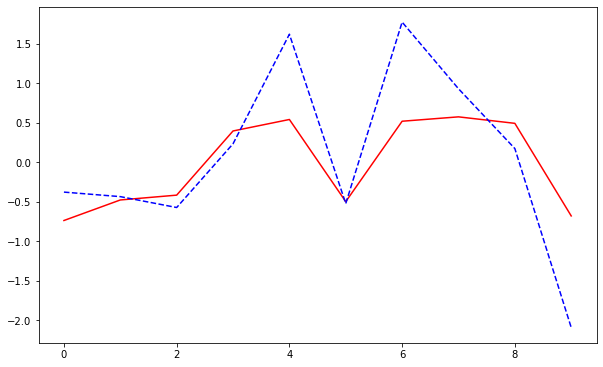

In [20]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
ax.plot(W[:, -1], 'b--')

In [21]:
print('WEIGHT')
print('before training,', w_before_training)
print('after training,', w_after_training) 
print('initialisation : ', W[:, :-1])

WEIGHT
before training, Parameter containing:
tensor([[ 0.0169, -0.0019,  0.0170,  ..., -0.0241, -0.0360,  0.0229],
        [ 0.0238, -0.0609,  0.0034,  ...,  0.0620,  0.0529, -0.0173],
        [ 0.0468,  0.0251, -0.0294,  ..., -0.0145, -0.0094,  0.0009],
        ...,
        [ 0.0546,  0.0003,  0.0188,  ...,  0.0113,  0.0180, -0.0548],
        [ 0.0403,  0.0150, -0.0277,  ..., -0.0386, -0.0067,  0.0130],
        [-0.0191,  0.0325, -0.0162,  ...,  0.0267, -0.0579, -0.0207]],
       requires_grad=True)
after training, Parameter containing:
tensor([[-0.3351,  0.8024, -0.5234,  ..., -0.4751,  0.8346, -0.7978],
        [-0.5213,  0.4988,  0.4731,  ...,  0.1056, -0.2070,  0.0676],
        [-0.5412, -1.0722, -0.6668,  ...,  0.6487, -0.5048, -0.4837],
        ...,
        [ 0.5180, -0.6421,  0.4584,  ..., -0.4315,  0.5273,  0.3667],
        [-0.2323,  0.6414,  0.7907,  ...,  0.4707, -0.0429, -0.4017],
        [-0.1725,  0.4456, -0.4954,  ...,  0.2502,  0.3921,  0.6266]],
       requires_grad=

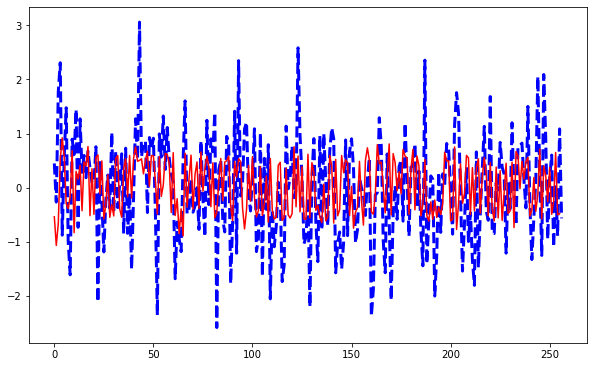

In [22]:
i_digit = 2
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[i_digit, :], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')

On voit que les biais et les poids ont changé après l'apprentissage pour se rapprocher de ceux de l'intialisation

## labels Poisson

The [Poisson distribution](https://numpy.org/devdocs/reference/random/generated/numpy.random.poisson.html) is the limit of the binomial distribution for large N.

In [23]:
X, p, y, e = get_data(W, seed=seed, N_batch=100, X_type='poisson')
logistic_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)


Iteration: 0 - Loss: 0.70773
Iteration: 16 - Loss: 0.35355
Iteration: 32 - Loss: 0.23677
Iteration: 48 - Loss: 0.16733
Iteration: 64 - Loss: 0.12319
Iteration: 80 - Loss: 0.09441
Iteration: 96 - Loss: 0.07488
Iteration: 112 - Loss: 0.06112
Iteration: 128 - Loss: 0.05105
Iteration: 144 - Loss: 0.04347
Iteration: 160 - Loss: 0.03759
Iteration: 176 - Loss: 0.03293
Iteration: 192 - Loss: 0.02917
Iteration: 208 - Loss: 0.02608
Iteration: 224 - Loss: 0.02351
Iteration: 240 - Loss: 0.02133
Iteration: 256 - Loss: 0.01948
Iteration: 272 - Loss: 0.01789
Iteration: 288 - Loss: 0.01651
Iteration: 304 - Loss: 0.01529
Iteration: 320 - Loss: 0.01423
Iteration: 336 - Loss: 0.01328
Iteration: 352 - Loss: 0.01244
Iteration: 368 - Loss: 0.01169
Iteration: 384 - Loss: 0.01101
Iteration: 400 - Loss: 0.01039
Iteration: 416 - Loss: 0.00983
Iteration: 432 - Loss: 0.00933
Iteration: 448 - Loss: 0.00886
Iteration: 464 - Loss: 0.00844
Iteration: 480 - Loss: 0.00805
Iteration: 496 - Loss: 0.00769
Iteration: 512 -

In [25]:
X


array([[0.5, 0.5, 1. , ..., 0.5, 0.5, 0.5],
       [0. , 0.5, 2. , ..., 1. , 1. , 0.5],
       [1. , 1. , 0.5, ..., 0.5, 1.5, 0.5],
       ...,
       [0. , 0.5, 0.5, ..., 1. , 0. , 0.5],
       [0. , 1. , 1.5, ..., 1. , 1. , 0. ],
       [0.5, 0. , 0.5, ..., 0. , 1. , 0.5]])

In [ ]:
i_digit = 2
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[i_digit, :], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')

ça "marche" toujours: un label poisson permet toujours de superviser l'apprentissage:

## labels binaires

In [ ]:
X, p, y, e = get_data(W, seed=seed, N_batch=10000, X_type='binary')
logistic_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)

In [ ]:
i_digit = 2
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[i_dvigit, :], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')

On voit que les biais et les poids ont changé après l'apprentissage pour se rapprocher de ceux de l'intialisation

# Un modele réaliste de courbes d'accord

## Définition de probabilités de firing des neurones, par classe

Text(0.5, 0, 'address')

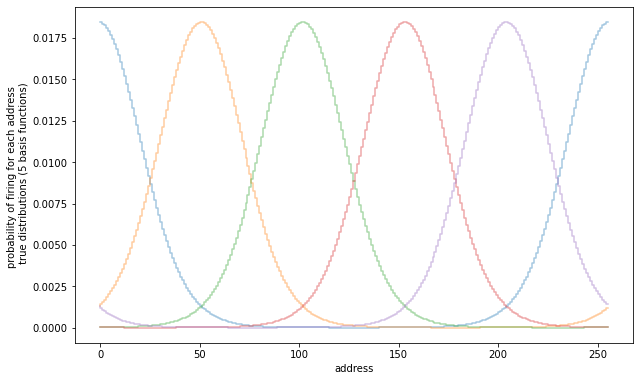

In [13]:
N_trials = 2**11 # number of trials
p1 = .01 # average firing probability
N = 2**8 # number of addresses
K = 5 # number of patterns
sigma = .51 # bandwidth

# a simple circular function to generate patterns
def von_mises(j, N, sigma):
    p = np.exp( np.cos(2*np.pi* (np.linspace(0, 1, N, endpoint=False) -j/N)) / sigma**2)
    p /= p.sum()
    return p

def stack(K, N, sigma):
    p = np.zeros((K, N))
    for k in range(K):
        p[k, :] = von_mises(k*N/K, N, sigma)
    return p

p_true = stack(K, N, sigma)

N_hyp = p_true.shape[0]
fig, ax = plt.subplots(1, 1, figsize=figsize)
for i_test in range(N_hyp):
    ax.step(np.arange(N), p_true[i_test, :], alpha=.4)
ax.set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')

In [14]:
seed = 2402
N = 256 # nombre de valeurs de l'entrée
K = 10 # nombre de classes
N_batch = 10000 # nombre d'échantillons
seed = 1973

#np.random.seed(seed!)
#W = np.random.randn(N+1, n_classes) # FIXED design matrix of weights (w) according to classes
p_true = stack(K, N, sigma)

In [15]:
p_true.shape

(10, 256)

On redéfinit p_true avec nos entrées (N) et nos sorties (K = n_classes)

ValueError: x and y must have same first dimension, but have shapes (256,) and (255,)

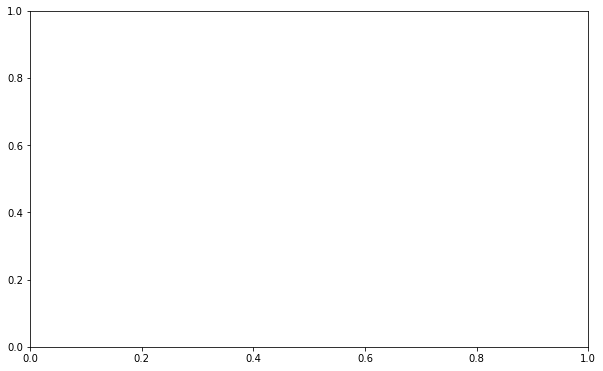

In [35]:
N_hyp = N
fig, ax = plt.subplots(1, 1, figsize=figsize)
for i_test in range(N_hyp):
    ax.step(np.arange(N), p_true[i_test,:-1]) #une courbe par pattern 
ax.set_ylabel('ground_true probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')


On détermine l'activité de nos N neurones lorsqu'ils encodent un groupe polychrone. P_true correspond à la proba de firing de chaque neurone pour chaque classe, c'est notre ground_true, notre sortie.

## Définition des poids à partir de la sortie & nouvelle initialisation 

In [16]:
p_true = np.hstack((p_true, 0.1*np.ones((K, 1))))

In [17]:
W = np.log(p_true/(1-p_true))

A partir de l'activité que les neurones ont lorsqu'ils encodent un groupe polychrone, donc __à partir de la sortie, on définit des poids pour classer nos entrées X__ dans les différentes classes : On connait l'activité des neurones quand un pattern d'interet est encodé, donc en définissant des poids à partir de cette activité, on sera en mesure de déterminer un __X*W plus élevé pour les entrées ayant un taux de décharge proche de la proba de firing true__ que pour celles ayant un X plus éloigné de p_true, ce qui augmentera leur chance de classification par rapport à celles ayant une activité plus élpoignée de p_true. 

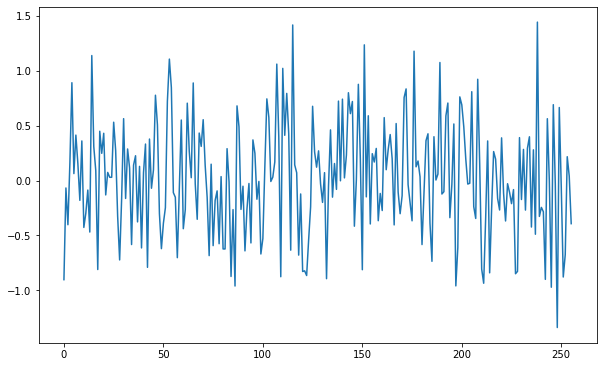

In [18]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(np.arange(N), X[0, :])

In [19]:
X, p, y, e = get_data(W, seed=seed, N_batch=N_batch)

On rappelle la fonction __get_data__ avec de nouveaux W pour chaque classe, définis à partir de proabilité de firing des neurones. La fonction get_data va donc attribuer une nouvelle importance aux entrées (un nouveau e), qui, une fois transmformées selon la regression logistique seront classées. On récupère donc une nouvelle probabilité de classification (p) et une nouvelle classification (y).

### Visualisation des nouvelles sorties de l'initialisation 

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(e[:,1],p[:,1]) 
ax.scatter(e[:,1],y[:,1], marker="x", color="red") 
#ordre de grandeur de e bizarre.. 

Les probabilités de classification des évidences (reçues par les neurones de classes) sont beaucoup moins hasardeuses..

In [ ]:
X_1 = np.mean(X, 1)
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(X_1,p[:,1]) 
ax.scatter(X_1,y[:,1],marker="x", color="red")

# pourquoi X est centré sur 0 ? l'ordre de grandeur de X ne correspond pas à une e de -30:30 avec des W -3:3...

Meme les probabilités de classification des entrées sont beaucoup plus ordonnées. Quasi toutes les entrées ont été classifié avec ' assurance '.

__On peut donc élaborer des poids intéressant à partir des probabilités de sortie.__

## Nouvel apprentissage

In [20]:
X, p, y, e = get_data(W, seed=seed, N_batch=100) 
logistic_model, loss = fit_data(X, y, verbose=True) #apprentissage avec W fixé à partir de p 
print("Final loss =", loss)

NameError: name 'fit_data' is not defined

In [21]:
y.shape

(100, 10)

On réentraine notre réseau pour qu'il apprenne à classer les entrées de la même façon que pendant la nouvelle initialisation. Pour se rapprocher du nouveau y, il faudra qu'il apprenne les nouveaux poids qu'on a implémentés. 

L'apprentissage est meilleur en augmentant le batch
Il faut quand même 1 000 000 de batch pour que l'apprentissage soit ok, pourquoi ? alors que pour le premier apprentissage, il ne suffisait que de 1000 batch ? est ce qu'on pourrait changer des paramètres pour l'améliorer ? 

### Visualisation des poids appris pendant l'apprentissage

In [ ]:
i_digit = 2 
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[i_digit, :-1], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')
ax.set_ylabel('weight')
ax.set_xlabel('address')

Visualisation des poids de toutes les classes pdt initialisation et après apprentissage

In [ ]:
#pourquoi les faire passer dans des sigmoides ? 

fig, ax = plt.subplots(figsize=figsize)
ax.plot(sigmoid(W[:-1, :]), '--', lw=3)
ax.plot(sigmoid(logistic_model.linear.weight[:, :].detach().numpy().T), '-')
ax.set_ylabel('weights')
ax.set_xlabel('address')

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[:, :-1].T, '--', lw=3)
ax.plot(logistic_model.linear.weight[:, :].detach().numpy().T, '-')
ax.set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')

Là où il ya des fortes probabilités de firing, il y a de forst poids. Pour l'instant, les poids fixés et les poids appris ont la même allure et la même proportionalité mais ils n'ont pas le même ordre de grandeur

--------------------------------------------------------------------

Avec des rasters plots synthetiques, on pourra connaître les probabilités de firing des neurones en fonction des groupes polychrones. A partir de cette sortie, on pourra déterminer des poids optimaux pour la classification des entrées. On entrainera notre réseau de sorte à ce qu'il aprenne à appliquer ces poids à ses entrées afin de reconnaitre l'occurrence d'un groupe polychrone. 
-> __APPRENTISSAGE SUPERVISE__


Avec cette technique, on connait le pattern des groupes polychrones. Si on veut chercher dans des données, l'occurence de ces groupes polychrones sans que nous sachions à quel moment est ce qu'ils arrivent, il y a de grande chance pour que la detection (ou alors à partir de ça on fera un apprentissage ?) soit efficace et qu'on connaisse le moment d'occurrence des PGs.


-> Je pensais rapprocher cette idée à l'__apprentissage semi suppervisé__ mais je ne comprends pas __1.__ où est l'apprentissage, __2.__ à partir de quoi se fait il ? Comment le réseau apprend ce qui est bon ou mauvais ? 

